In [ ]:
Google PageSpeed Insight API KEY: *******************************

In [ ]:
import pandas as pd
import requests
import time
from google.colab import files

# Read CSV file and assign column name
df_urls = pd.read_csv('top-300.csv', header=None, names=['url'])

print(df_urls.head())

                                url
0           https://www.google.com/
1         https://www.facebook.com/
2           https://googleapis.com/
3            https://www.apple.com/
4  https://www.microsoft.com/en-us/


In [ ]:
# Definitions for categorization
def categorize_cls(cls_score):
    if cls_score is None:
        return 'N/A'
    if cls_score <= 0.1:
        return 'Good'
    elif cls_score <= 0.25:
        return 'Needs Improvement'
    else:
        return 'Poor'

def categorize_fcp(fcp_score):
    if fcp_score is None:
        return 'N/A'
    if fcp_score <= 1.8:
        return 'Good'
    elif fcp_score <= 3.0:
        return 'Needs Improvement'
    else:
        return 'Poor'

def categorize_lcp(lcp_score):
    if lcp_score is None:
        return 'N/A'
    if lcp_score <= 2.5:
        return 'Good'
    elif lcp_score <= 4.0:
        return 'Needs Improvement'
    else:
        return 'Poor'

In [ ]:
# Function to get the performance metrics from google pagespeed insights api
def get_performance_metrics(url, api_key=None):
    api_url = 'https://www.googleapis.com/pagespeedonline/v5/runPagespeed'
    params = {
        'url': url,
        'strategy': 'mobile',
    }
    if api_key:
        params['key'] = api_key

    try:
        response = requests.get(api_url, params=params, timeout=30)
        if response.status_code == 200:
            result = response.json()
            metrics = {}
            try:
                field_metrics = result['loadingExperience']['metrics']
                metrics['cls'] = field_metrics.get('CUMULATIVE_LAYOUT_SHIFT_SCORE', {}).get('percentile', None)
                metrics['fcp'] = field_metrics.get('FIRST_CONTENTFUL_PAINT_MS', {}).get('percentile', None)
                metrics['lcp'] = field_metrics.get('LARGEST_CONTENTFUL_PAINT_MS', {}).get('percentile', None)

                # Normalize CLS score
                if metrics['cls'] is not None:
                    metrics['cls'] = metrics['cls'] / 100
                # Normalize other metrics from milliseconds to seconds
                for key in ['fcp', 'lcp']:
                    if metrics[key] is not None:
                        metrics[key] = metrics[key] / 1000
                # Categorize the metrics
                metrics['cls_category'] = categorize_cls(metrics['cls'])
                metrics['fcp_category'] = categorize_fcp(metrics['fcp'])
                metrics['lcp_category'] = categorize_lcp(metrics['lcp'])
                return metrics
            except KeyError:
                # Metrics not available
                return None
        else:
            print(f"Error fetching data for {url}: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request exception for {url}: {e}")
        return None

In [ ]:
# Get the api response and save to a csv file
api_key = '*************'

performance_data = []

for index, row in df_urls.iterrows():
    url = row['url']
    print(f"Processing {index + 1}/{len(df_urls)}: {url}")
    # Ensure the URL has the proper scheme
    if not url.startswith(('http://', 'https://')):
        url = 'https://' + url  # You can choose 'http://' or 'https://' based on your needs
    metrics = get_performance_metrics(url, api_key)
    if metrics:
        metrics['url'] = url
        performance_data.append(metrics)
    else:
        performance_data.append({'url': url, 'cls': None, 'fcp': None, 'lcp': None,
                                 'cls_category': 'N/A', 'fcp_category': 'N/A',
                                 'lcp_category': 'N/A'})
    time.sleep(1)

df_metrics = pd.DataFrame(performance_data)
# Save the DataFrame to output CSV file
df_metrics.to_csv('performance_metrics.csv', index=False)

Processing 1/300: https://www.google.com/
Processing 2/300: https://www.facebook.com/
Processing 3/300: https://googleapis.com/
Processing 4/300: https://www.apple.com/
Processing 5/300: https://www.microsoft.com/en-us/
Processing 6/300: https://www.youtube.com/
Processing 7/300: https://www.cloudflare.com/
Processing 8/300: https://www.instagram.com/
Processing 9/300: https://www.netflix.com/
Processing 10/300: https://www.gstatic.com/
Processing 11/300: https://www.linkedin.com/
Processing 12/300: https://www.microsoft.com/en-us/microsoft-365/outlook/email-and-calendar-software-microsoft-outlook?deeplink=%2fowa%2f&sdf=0
Request exception for https://www.microsoft.com/en-us/microsoft-365/outlook/email-and-calendar-software-microsoft-outlook?deeplink=%2fowa%2f&sdf=0: HTTPSConnectionPool(host='www.googleapis.com', port=443): Read timed out. (read timeout=30)
Processing 13/300: https://marketingplatform.google.com/about/enterprise/
Processing 14/300: https://www.office.com/
Processing 15

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the performance metrics data
df_metrics = pd.read_csv('performance_metrics.csv')
print(df_metrics.head())

df_metrics['cls'] = pd.to_numeric(df_metrics['cls'], errors='coerce')

# Remove entries with missing cls score
df_cls_clean = df_metrics.dropna(subset=['cls'])

# Sort by cls score in descending order (higher CLS is worse)
df_cls_sorted = df_cls_clean.sort_values(by='cls', ascending=False)

# Select top 30 worst CLS sites
top_30_worst_cls = df_cls_sorted.head(30)

# Output results
print("\nTop 10 Websites with the Worst CLS Scores:")
print(top_30_worst_cls[['url', 'cls']])

    cls    fcp    lcp cls_category       fcp_category       lcp_category  \
0  0.00  0.628  0.907         Good               Good               Good   
1  0.02  1.732  3.384         Good               Good  Needs Improvement   
2   NaN    NaN    NaN          NaN                NaN                NaN   
3  0.00  2.708  2.803         Good  Needs Improvement  Needs Improvement   
4  0.00  2.252  2.485         Good  Needs Improvement               Good   

                                url  
0           https://www.google.com/  
1         https://www.facebook.com/  
2           https://googleapis.com/  
3            https://www.apple.com/  
4  https://www.microsoft.com/en-us/  

Top 10 Websites with the Worst CLS Scores:
                                                   url   cls
79                                 https://flickr.com/  0.77
5                             https://www.youtube.com/  0.47
27           https://www.youtube.com/?feature=youtu.be  0.47
74                         

In [ ]:
sns.set(style="whitegrid")

# Define the metrics and their full name for title
metrics = ['cls_category', 'fcp_category', 'lcp_category']
metric_names = {
    'cls_category': 'Cumulative Layout Shift (CLS)',
    'fcp_category': 'First Contentful Paint (FCP)',
    'lcp_category': 'Largest Contentful Paint (LCP)'
}

<ipython-input-10-c9ac80b166d6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=metric, data=df_metrics, order=order, palette='viridis')


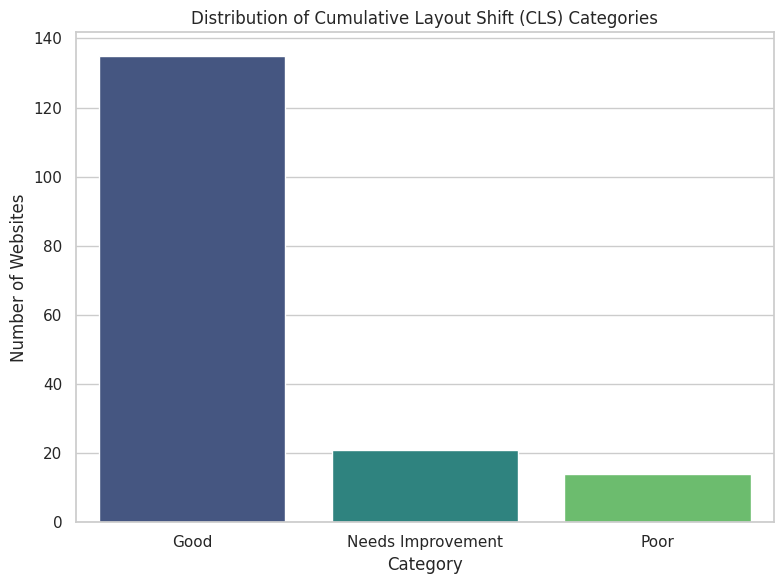

<ipython-input-10-c9ac80b166d6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=metric, data=df_metrics, order=order, palette='viridis')


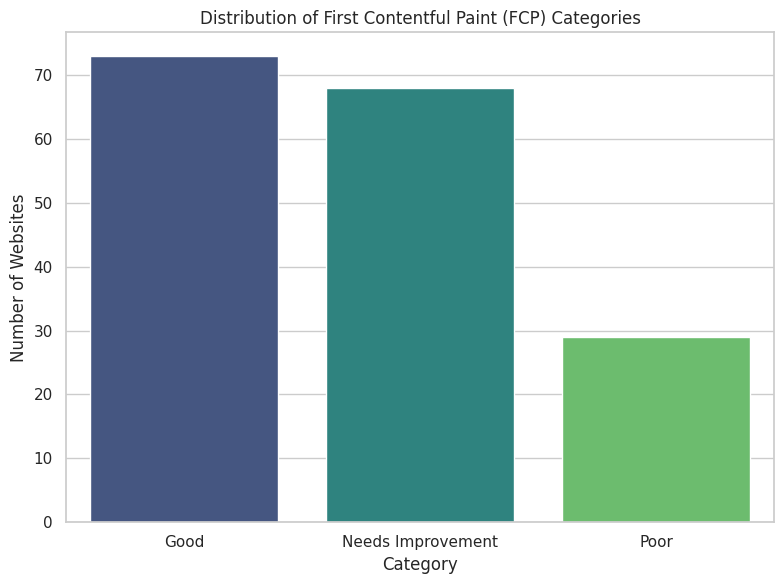

<ipython-input-10-c9ac80b166d6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=metric, data=df_metrics, order=order, palette='viridis')


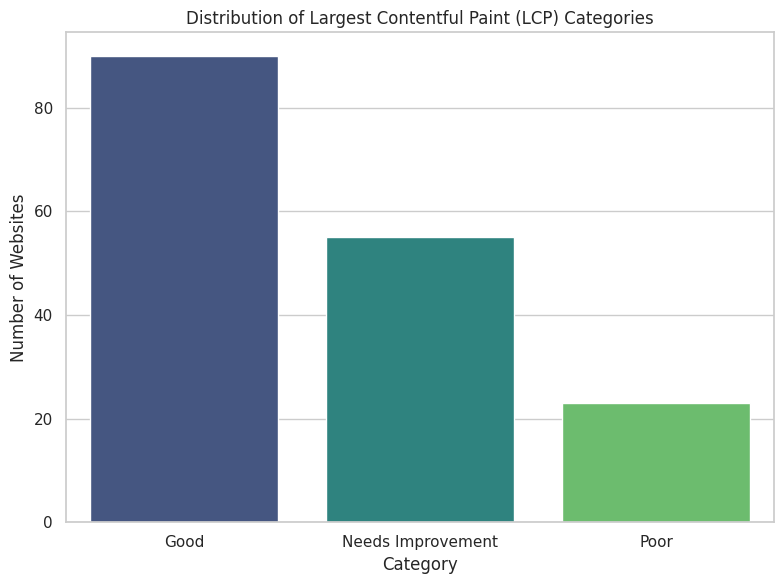

In [ ]:
# Generate bar charts
for metric in metrics:
    plt.figure(figsize=(8, 6))
    order = ['Good', 'Needs Improvement', 'Poor']
    sns.countplot(x=metric, data=df_metrics, order=order, palette='viridis')
    plt.title(f'Distribution of {metric_names[metric]} Categories')
    plt.xlabel('Category')
    plt.ylabel('Number of Websites')
    plt.tight_layout()
    plt.show()

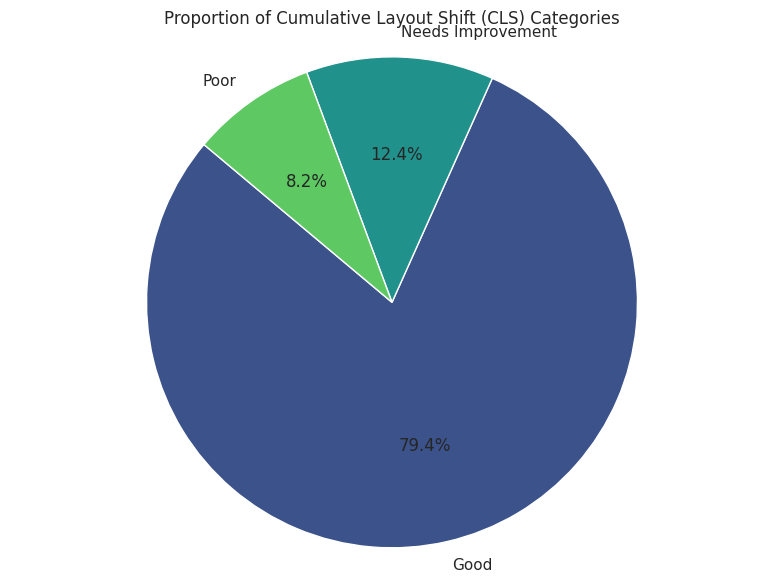

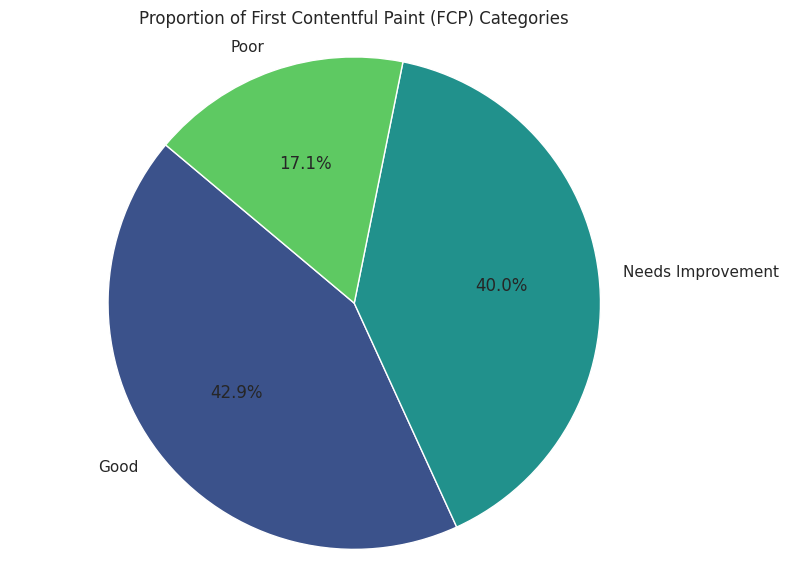

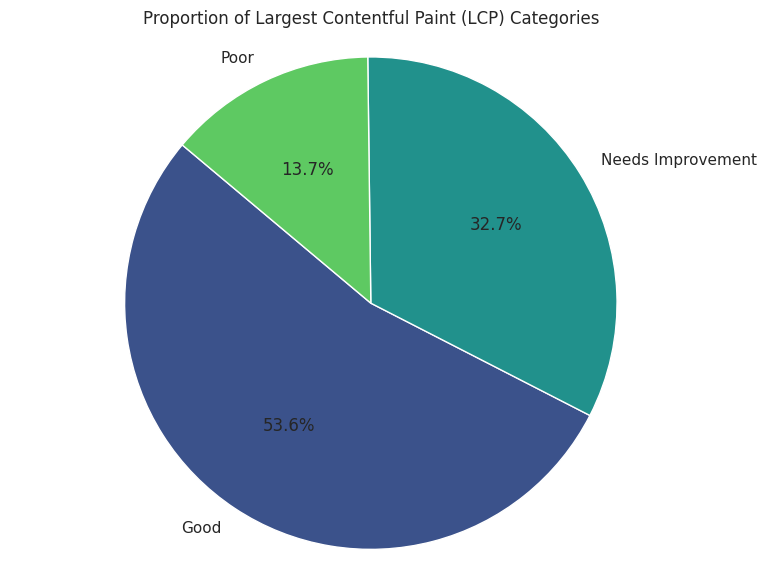

In [ ]:
# Generate pie charts
for metric in metrics:
    data = df_metrics[metric].value_counts().reindex(['Good', 'Needs Improvement', 'Poor'])
    data = data.dropna()
    plt.figure(figsize=(8, 6))
    plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', n_colors=3))
    plt.title(f'Proportion of {metric_names[metric]} Categories')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

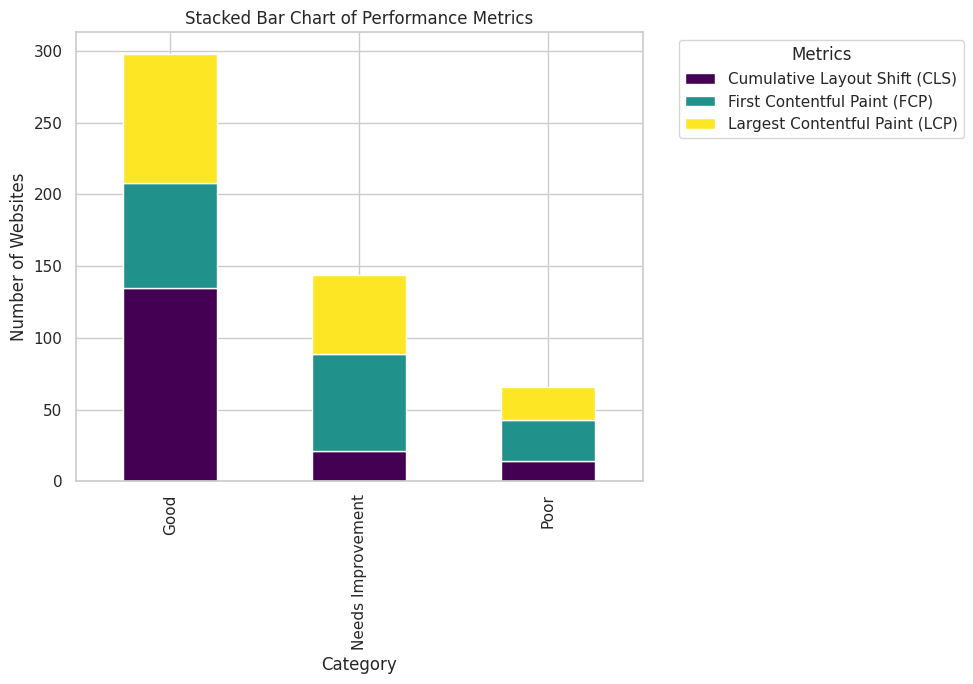

In [ ]:
# Prepare data for the stacked bar chart
categories = ['Good', 'Needs Improvement', 'Poor']
stacked_data = pd.DataFrame(index=categories)

for metric in metrics:
    counts = df_metrics[metric].value_counts().reindex(categories)
    stacked_data[metric_names[metric]] = counts

stacked_data = stacked_data.fillna(0)

# Plot stacked bar chart
stacked_data.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')
plt.title('Stacked Bar Chart of Performance Metrics')
plt.xlabel('Category')
plt.ylabel('Number of Websites')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

          cls       fcp       lcp
cls  1.000000  0.214646  0.417960
fcp  0.214646  1.000000  0.817559
lcp  0.417960  0.817559  1.000000


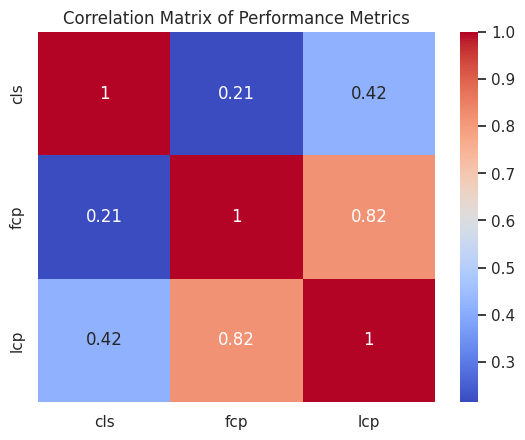

In [ ]:
# Calculate correlation matrix
numeric_metrics = df_metrics[['cls', 'fcp', 'lcp']].dropna()
correlation_matrix = numeric_metrics.corr()
print(correlation_matrix)

# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Performance Metrics')
plt.show()

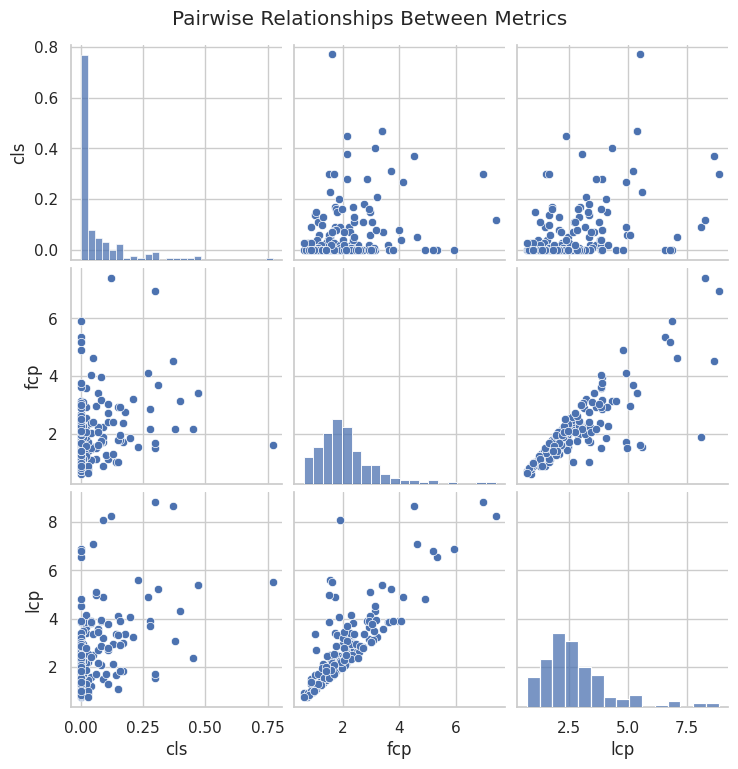

In [ ]:
# Pairwise relationships
sns.pairplot(numeric_metrics)
plt.suptitle('Pairwise Relationships Between Metrics', y=1.02)
plt.show()